#### Setup Codes

In [1]:
%load_ext autoreload
%autoreload 2

##### Google Colab Setup
we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'for_knn.py', 'linear_classifier.py', 'custom_model_utils', 'Convolutional_Neural_Network', '_utils.py', 'save.py', '_word_processing.py', '_layers.py', 'enc2dec', 'data', 'models', 'colab_utils', 'visualize.py']


### Load PASCAL VOC 2007 data

PASCAL VOC 2007 download info : https://pytorch.org/vision/main/generated/torchvision.datasets.VOCDetection.html

In [ ]:
from torch.utils.data import DataLoader

# custom packages
from data.pascal_voc import PASCALVOC, inverse_image
from data.cv_utils import detection_visualizer

In [ ]:
train_dataset = PASCALVOC(root='.', year='2007', split='train', download=True, image_size=224)
val_dataset = PASCALVOC(root='.', year='2007', split='val', download=True, image_size=224)

In [ ]:
import multiprocessing
train_loader = DataLoader(train_dataset, batch_size=32, pin_memory=True, num_workers=multiprocessing.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=1, pin_memory=True, num_workers=multiprocessing.cpu_count())

## Faster R-CNN (1)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt

In [ ]:
def center_to_corner(center_coords, width, heigth):
  x_ctr, y_ctr = center_coords[0], center_coords[1]

  return torch.hstack((x_ctr - width * 0.5,
                       y_ctr - heigth * 0.5,
                       x_ctr + width * 0.5,
                       y_ctr + heigth * 0.5))

In [ ]:
def get_anchors(locations, base_size=16, ratios=[0.5, 1.0], scales=[8]):

    ratios = torch.tensor(ratios)
    scales = torch.tensor(scales)

    size = (base_size * scales) ** 2
    size_ratios = size / ratios

    width = torch.sqrt(size_ratios)
    heigth = size / width

    width = width.unsqueeze(1)
    heigth = heigth.unsqueeze(1)

    anchors = torch.vstack([center_to_corner(_loc, width, heigth) for _loc in locations])
    return anchors

In [ ]:
def get_locations(feat_height, feat_width, stride):

  x = torch.arange(0.5, feat_width + 0.5, step=1) * stride
  y = torch.arange(0.5, feat_height + 0.5, step=1) * stride
  grid_x, grid_y = torch.meshgrid(x, y)

  x = grid_x.reshape(-1)
  y = grid_y.reshape(-1)

  locations = torch.vstack((x, y)).T
  return locations

In [ ]:
def generate_anchors(img_size=(224, 224), stride=16, ratios=[0.5, 1.0, 2.0], scales=[8]):

  feat_height = img_size[0] // stride
  feat_width = img_size[1] // stride
  locations = get_locations(feat_height, feat_width, stride)
  anchors = get_anchors(locations, stride, ratios, scales)
  return anchors

### Sanity Check

In [ ]:
def visualize_locations(img, points):
  img = (img * 255).permute(1, 2, 0)
  img_copy = np.array(img).astype("uint8")
  _, ax = plt.subplots(frameon=False)

  ax.axis("off")
  ax.imshow(img_copy)


  points_x = [t[0] for t in points]
  points_y = [t[1] for t in points]
  ax.scatter(points_x, points_y, color="yellow", s=24)

  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


size of locations: torch.Size([196, 2])



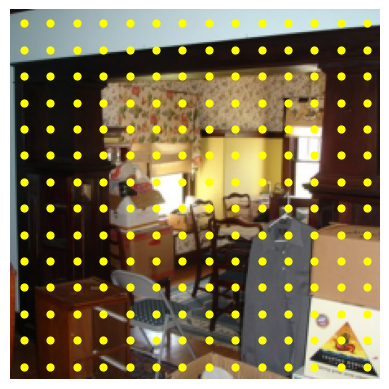

In [ ]:
feat_shape = (2, 64, 14, 14)
stride = 16

locations = get_locations(feat_shape[2], feat_shape[3], stride)
print(f"size of locations: {locations.shape}\n")

# Visualize all the locations on first image from training data.
image = inverse_image(val_dataset[0][1])
visualize_locations(image, points=locations.tolist())

In [ ]:
def get_anchors_from_deltas(anchors, deltas):

    # convert corner to center
    x_ctr = (anchors[:, :, 0] + anchors[:, :, 2]) / 2
    y_ctr = (anchors[: ,:, 1] + anchors[: ,:, 3]) / 2
    w = anchors[:, :, 2] - anchors[:, :, 0]
    h = anchors[:, :, 3] - anchors[:, :, 1]

    dx_ctr = x_ctr + torch.mul(w, deltas[:, :, 0])
    dy_ctr = y_ctr + torch.mul(h, deltas[:, :, 1])
    dw = torch.mul(w, deltas[:, :, 2].exp())
    dh = torch.mul(h, deltas[:, :, 3].exp())

    boxes = torch.empty_like(deltas)
    boxes[:, :, 0] = dx_ctr - dw / 2
    boxes[:, :, 1] = dy_ctr - dh / 2
    boxes[:, :, 2] = dx_ctr + dw / 2
    boxes[:, :, 3] = dy_ctr + dh / 2

    boxes[deltas[:, :, 0] == -1e8] = -1e8

    return boxes

In [ ]:
def clip_boxes(proposals, image_size):

    proposals[:, :, 0] = proposals[:, :, 0].clamp(0, image_size[0])
    proposals[:, :, 1] = proposals[:, :, 1].clamp(0, image_size[1])
    proposals[:, :, 2] = proposals[:, :, 2].clamp(0, image_size[0])
    proposals[:, :, 3] = proposals[:, :, 3].clamp(0, image_size[1])
    return proposals

In [ ]:
anchors = generate_anchors()
anchors = anchors.expand(2, -1, 4)

# random deltas for test
bbox_deltas = torch.randn(2, 12, 14, 14)
bbox_deltas = bbox_deltas.permute(0, 2, 3, 1).contiguous()
bbox_deltas = bbox_deltas.view(2, -1, 4)

In [ ]:
proposals = get_anchors_from_deltas(anchors, bbox_deltas)
proposals = clip_boxes(proposals, image_size=(224,224))

In [ ]:
class PredictionNetwork(nn.Module):
    def __init__(self, feat_dim,
                 out_dim=512,
                 num_anchors=3):
        super().__init__()

        self.num_anchors = num_anchors

        # define the convrelu layers processing input feature map
        self.conv = nn.Sequential(*[
            nn.Conv2d(feat_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU()])

        # define bg/fg classifcation score layer
        self.pred_cls = nn.Conv2d(out_dim, self.num_anchors, kernel_size=1, stride=1)

        # define anchor box offset prediction layer
        self.pred_bbox = nn.Conv2d(out_dim, 4 * self.num_anchors, kernel_size=1, stride=1)


    def forward(self, base_feat):

        batch_size = base_feat.size(0)
        feat = self.conv(base_feat)

        # get rpn classification score
        pred_cls = self.pred_cls(feat)

        # get rpn offsets to the anchor boxes
        pred_bbox = self.pred_bbox(feat)


        bbox_deltas = pred_bbox.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
        scores = pred_cls.permute(0, 2, 3, 1).contiguous().view(batch_size, -1)


        return bbox_deltas, scores

In [ ]:
# 0. extract feature
feat = torch.randn(2, 64, 14, 14)

prediction = PredictionNetwork(feat_dim=64,
                               out_dim=512,
                               num_anchors=3)

# 1. predict deltas, cls_score
bbox_deltas, scores = prediction(feat)

# 2. generate anchors
anchors = generate_anchors()
anchors = anchors.expand(2, -1, 4)

# 3. get proposals from deltas and anchors
proposals = get_anchors_from_deltas(anchors, bbox_deltas)
proposals = clip_boxes(proposals, image_size=(224,224))

print(f"proposals shape : {proposals.shape}")
print(proposals)

proposals shape : torch.Size([2, 588, 4])
tensor([[[  0.0000,   0.0000, 101.1200,  60.8279],
         [  0.0000,   0.0000,  66.6406,  82.3237],
         [  0.0000,   0.0000,  42.2216,  78.2937],
         ...,
         [103.0008, 185.2896, 224.0000, 224.0000],
         [111.0686, 158.2632, 224.0000, 224.0000],
         [184.2313,  85.6253, 224.0000, 224.0000]],

        [[  0.0000,   0.0000,  84.5175,  70.7878],
         [  0.0000,   0.0000,  83.1751,  91.2294],
         [  0.0000,   0.0000,  40.0532, 114.7570],
         ...,
         [194.6109, 163.7714, 224.0000, 224.0000],
         [117.8997, 131.4211, 224.0000, 224.0000],
         [179.4305,  62.9313, 224.0000, 224.0000]]], grad_fn=<CopySlices>)


In [ ]:
class ProposalLayer(nn.Module):
    def __init__(self,
                 img_size=(224, 224),
                 stride=16,
                 ratios=[0.5, 1.0, 2.0],
                 scales=[8],
                 pre_nms_topN=400,
                 post_nms_topN=100,
                 thresh=0.7):
        super().__init__()

        self.img_size = img_size
        self.pre_nms_topN = pre_nms_topN
        self.post_nms_topN = post_nms_topN
        self.thresh=thresh

        self.anchors = generate_anchors(img_size, stride, ratios, scales)
        self.num_anchors = self.anchors.size(0)


    def forward(self, scores, bbox_deltas):
        batch_size = scores.size(0)

        # 1. Convert anchors into proposals via bbox transformations
        self.anchors = self.anchors.expand(batch_size, -1, 4)
        proposals = get_anchors_from_deltas(self.anchors, bbox_deltas)

        # 2. clip predicted boxes to image
        proposals = clip_boxes(proposals, self.img_size)
        output = torch.zeros(batch_size, self.post_nms_topN, 5)

        for i in range(batch_size):
          _proposal = proposals[i]
          _scores = scores[i]

          topk = min(self.pre_nms_topN, _scores.shape[0])
          topk_scores, topk_idx = torch.topk(_scores, topk)
          topk_proposals = _proposal[topk_idx]

          _idx = torchvision.ops.nms(topk_proposals, topk_scores, self.thresh)
          keep_idx = _idx[:self.post_nms_topN]

          post_proposal = topk_proposals[keep_idx]

          num_proposal = post_proposal.size(0)
          output[i,:,0] = i
          output[i,:num_proposal,1:] = post_proposal

        return output, self.anchors

In [ ]:
# 0. extract feature
feat = torch.randn(2, 512, 7, 7)
prediction = PredictionNetwork(feat_dim=512,
                               out_dim=512,
                               num_anchors=3)

# 1. predict deltas, cls_score
bbox_deltas, scores = prediction(feat)

# 2. get proposals
proposal = ProposalLayer(img_size=(224, 224),
                         stride=32,
                         ratios=[0.5, 1.0, 2.0],
                         scales=[8],
                         pre_nms_topN=400,
                         post_nms_topN=100,
                         thresh=0.7)

output, anchors = proposal(scores, bbox_deltas)

print(f"proposal.shape: {output.shape}")